In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import os
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
!git clone https://github.com/juuu28/ricek_dataset.git

Cloning into 'ricek_dataset'...
remote: Enumerating objects: 6822, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 6822 (delta 3), reused 176 (delta 2), pack-reused 6638
Receiving objects: 100% (6822/6822), 650.44 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Updating files: 100% (5872/5872), done.


In [3]:
source_path = '/content/ricek_dataset/Train'

source_path_fapples = os.path.join(source_path, 'fresh_apple')
source_path_fbananas = os.path.join(source_path, 'fresh_banana')
source_path_fmango = os.path.join(source_path, 'fresh_mango')
source_path_rapples = os.path.join(source_path, 'rotten_apple')
source_path_rbananas = os.path.join(source_path, 'rotten_banana')
source_path_rmango = os.path.join(source_path, 'rotten_mango')
source_path_uapples = os.path.join(source_path, 'unripe_apple')
source_path_ubananas = os.path.join(source_path, 'unripe_banana')
source_path_umango = os.path.join(source_path, 'unripe_mango')

print(f"There are {len(os.listdir(source_path_fapples))} images of fresh apples.")
print(f"There are {len(os.listdir(source_path_fbananas))} images of fresh bananas.")
print(f"There are {len(os.listdir(source_path_fmango))} images of fresh mangoes.")
print(f"There are {len(os.listdir(source_path_rapples))} images of rotten apples.")
print(f"There are {len(os.listdir(source_path_rbananas))} images of rotten bananas.")
print(f"There are {len(os.listdir(source_path_rmango))} images of rotten mangoes.")
print(f"There are {len(os.listdir(source_path_uapples))} images of unripe apples.")
print(f"There are {len(os.listdir(source_path_ubananas))} images of unripe bananas.")
print(f"There are {len(os.listdir(source_path_umango))} images of unripe mangoes.")

There are 459 images of fresh apples.
There are 470 images of fresh bananas.
There are 288 images of fresh mangoes.
There are 618 images of rotten apples.
There are 1340 images of rotten bananas.
There are 286 images of rotten mangoes.
There are 268 images of unripe apples.
There are 133 images of unripe bananas.
There are 345 images of unripe mangoes.


In [4]:
labels = []
for class_ in os.listdir("/content/ricek_dataset/Train"):
    labels.append(class_)
NUM_LABELS = len(labels)

print(labels)

['rotten_banana', 'unripe_apple', 'fresh_apple', 'unripe_banana', 'rotten_apple', 'rotten_mango', 'unripe_mango', '_tokenization.txt', 'fresh_banana', 'fresh_mango']


In [5]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(rescale=1./255) 
  # train_datagen = ImageDataGenerator(rescale=1./255,
  #                                    rotation_range=40,
  #                                    width_shift_range=0.2,
  #                                    height_shift_range=0.2,
  #                                    shear_range=0.2,
  #                                    zoom_range=0.2,
  #                                    horizontal_flip=True,
  #                                    fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical', 
                                                      target_size=(240, 240))
  # train_generator = train_datagen.flow_from_directory(batch_size=32,
  #                                                directory=TRAINING_DIR,
  #                                                shuffle=True,
  #                                               classes=labels,
  #                                                target_size=(240,240), 
  #                                                subset="training",
  #                                                class_mode='categorical')

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(240, 240))
  # validation_generator = validation_datagen.flow_from_directory(batch_size=32,
  #                                                directory=VALIDATION_DIR,
  #                                                shuffle=True,
  #                                               classes=labels,
  #                                                target_size=(240,240), 
  #                                                subset="validation",
  #                                                class_mode='categorical')
  ### END CODE HERE
  return train_generator, validation_generator

In [6]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators('/content/ricek_dataset/Train', '/content/ricek_dataset/Valid')

Found 4207 images belonging to 9 classes.
Found 1076 images belonging to 9 classes.


In [7]:
train_generator.class_indices
class_names = list(train_generator.class_indices.keys())
class_names

['fresh_apple',
 'fresh_banana',
 'fresh_mango',
 'rotten_apple',
 'rotten_banana',
 'rotten_mango',
 'unripe_apple',
 'unripe_banana',
 'unripe_mango']

In [8]:
preprocess_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(240, 240, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
predictions = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
base_model.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    validation_steps=validation_generator.samples/validation_generator.batch_size, 
                    epochs=10, 
                    verbose=1)

Epoch 1/10
131/131 [==============================] - 154s 1s/step - loss: 0.5872 - accuracy: 0.7880 - val_loss: 0.3113 - val_accuracy: 0.8941
Epoch 2/10
131/131 [==============================] - 139s 1s/step - loss: 0.2464 - accuracy: 0.9111 - val_loss: 0.2921 - val_accuracy: 0.8959
Epoch 3/10
131/131 [==============================] - 143s 1s/step - loss: 0.1962 - accuracy: 0.9299 - val_loss: 0.2671 - val_accuracy: 0.9089
Epoch 4/10
131/131 [==============================] - 138s 1s/step - loss: 0.1741 - accuracy: 0.9337 - val_loss: 0.2534 - val_accuracy: 0.9257
Epoch 5/10
131/131 [==============================] - 142s 1s/step - loss: 0.1409 - accuracy: 0.9517 - val_loss: 0.2715 - val_accuracy: 0.9145
Epoch 6/10
131/131 [==============================] - 138s 1s/step - loss: 0.1138 - accuracy: 0.9577 - val_loss: 0.2139 - val_accuracy: 0.9275
Epoch 7/10
131/131 [==============================] - 142s 1s/step - loss: 0.1118 - accuracy: 0.9591 - val_loss: 0.2119 - val_accuracy: 0.9396

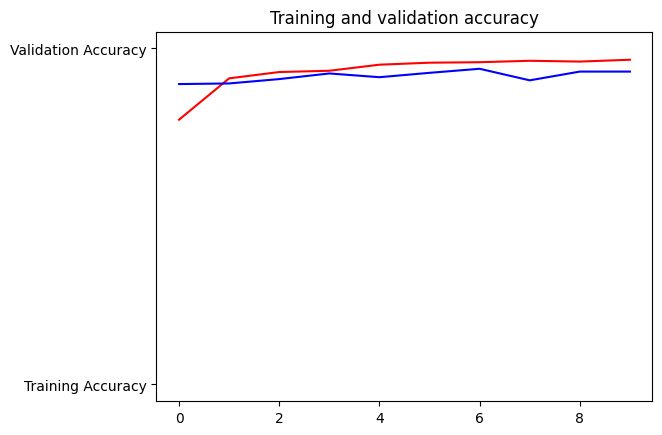

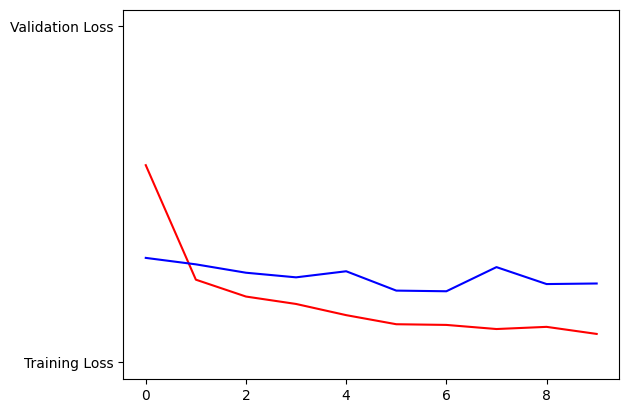

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [26]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(240,240))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  im_class = class_names[np.argmax(classes)]
  print(fn)
  print(classes)
  print("ini ", im_class)

Saving pisang_rusak.png to pisang_rusak (1).png
1/1 [==============================] - 0s 32ms/step
pisang_rusak.png
[[5.5098767e-06 6.0238905e-04 1.7990721e-04 6.6350844e-06 3.7647126e-04
  1.5096667e-03 9.9723095e-01 3.8471429e-05 4.9890012e-05]]
ini  unripe_apple


In [12]:
test_dir = '/content/ricek_dataset/Test'
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(240, 240))

Found 567 images belonging to 9 classes.


In [13]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  32  y:  32


In [14]:
pred = model.predict(x)

y_test = []
for i in pred:
    y_test.append(np.argmax(i))

y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

1/1 [==============================] - 1s 764ms/step


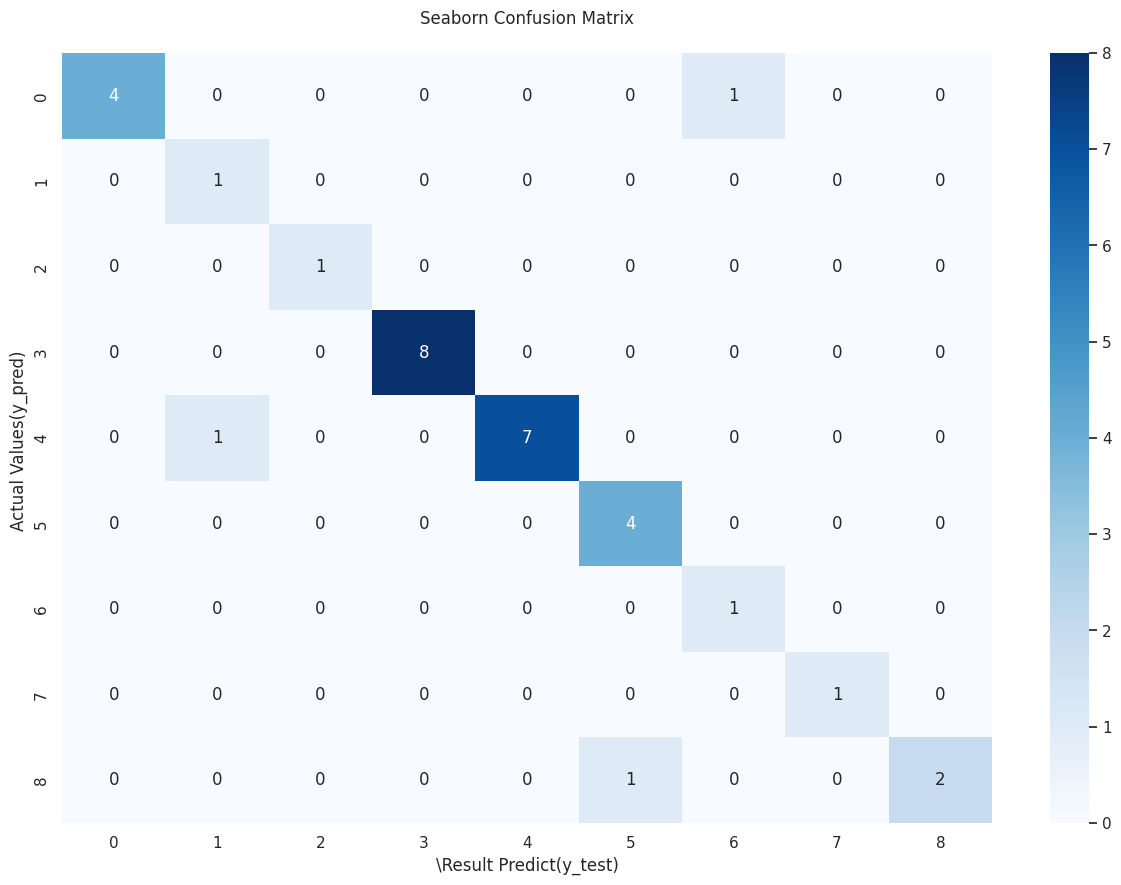

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('\Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ');

first image to predict
actual label: rotten_apple
1/1 [==============================] - 0s 41ms/step
predicted label: rotten_apple


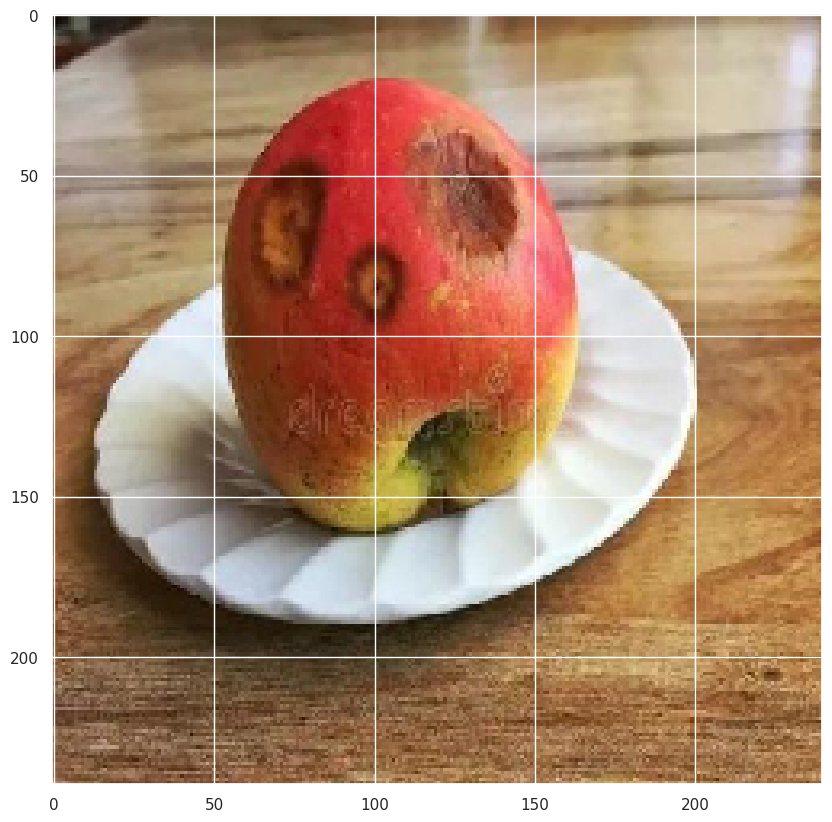

In [16]:
import numpy as np

for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = np.argmax(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


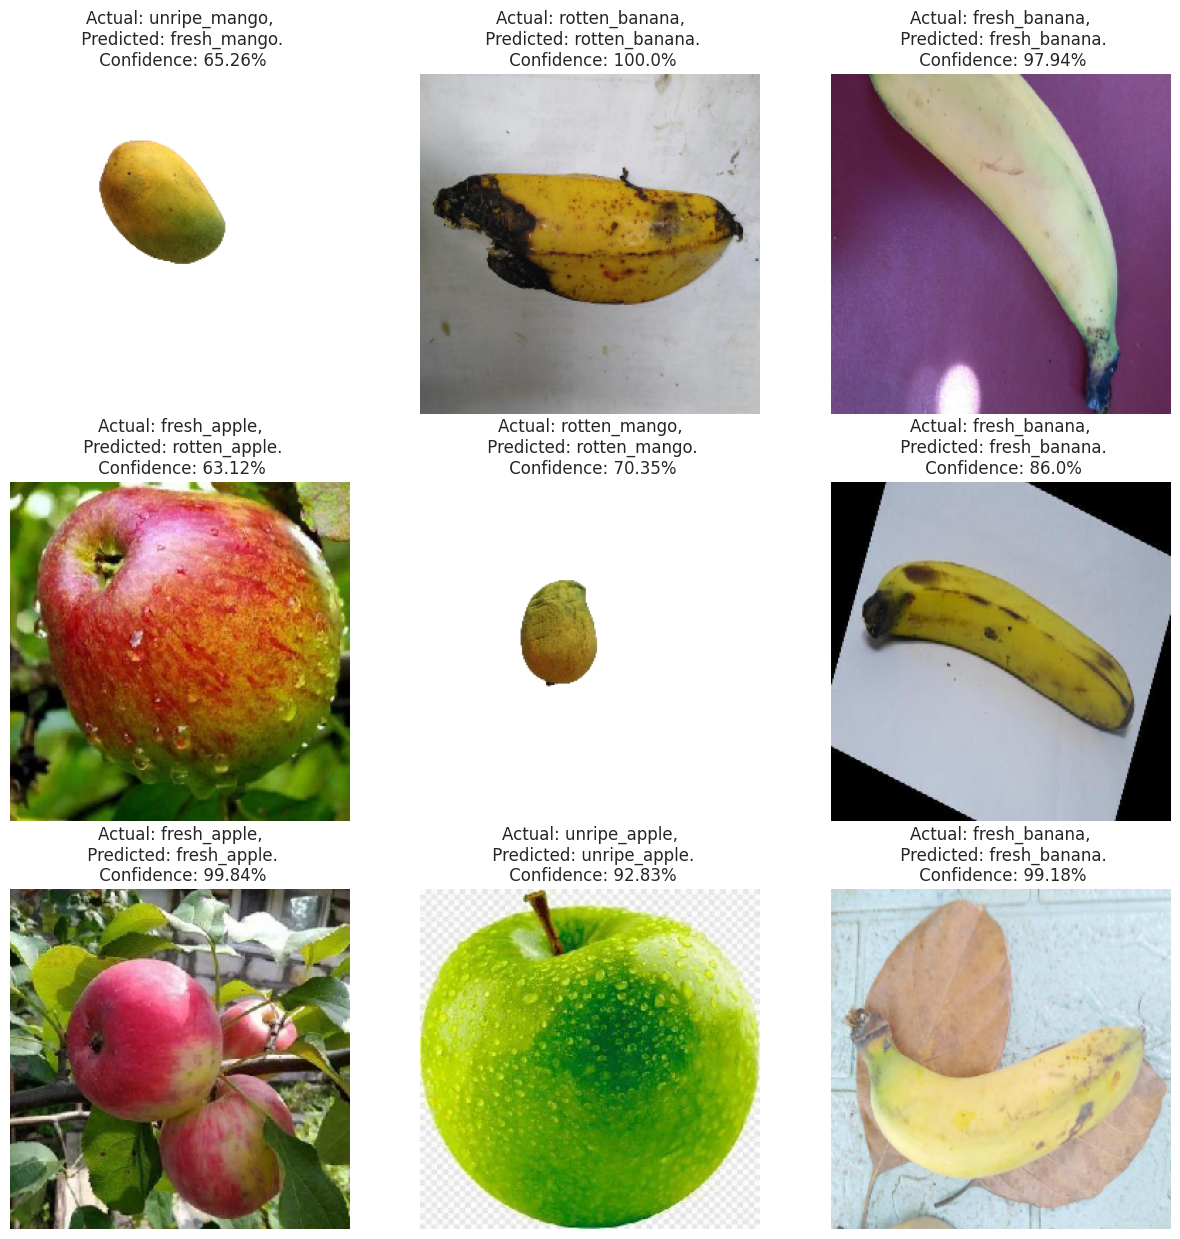

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [19]:
test2_dir = '/content/ricek_dataset/Testing Images'
test2_datagen = ImageDataGenerator(rescale=1/255)
test2_generator = test2_datagen.flow_from_directory(directory=test2_dir,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(240, 240))

Found 19 images belonging to 9 classes.


1/1 [==============================] - 0s 33ms/step


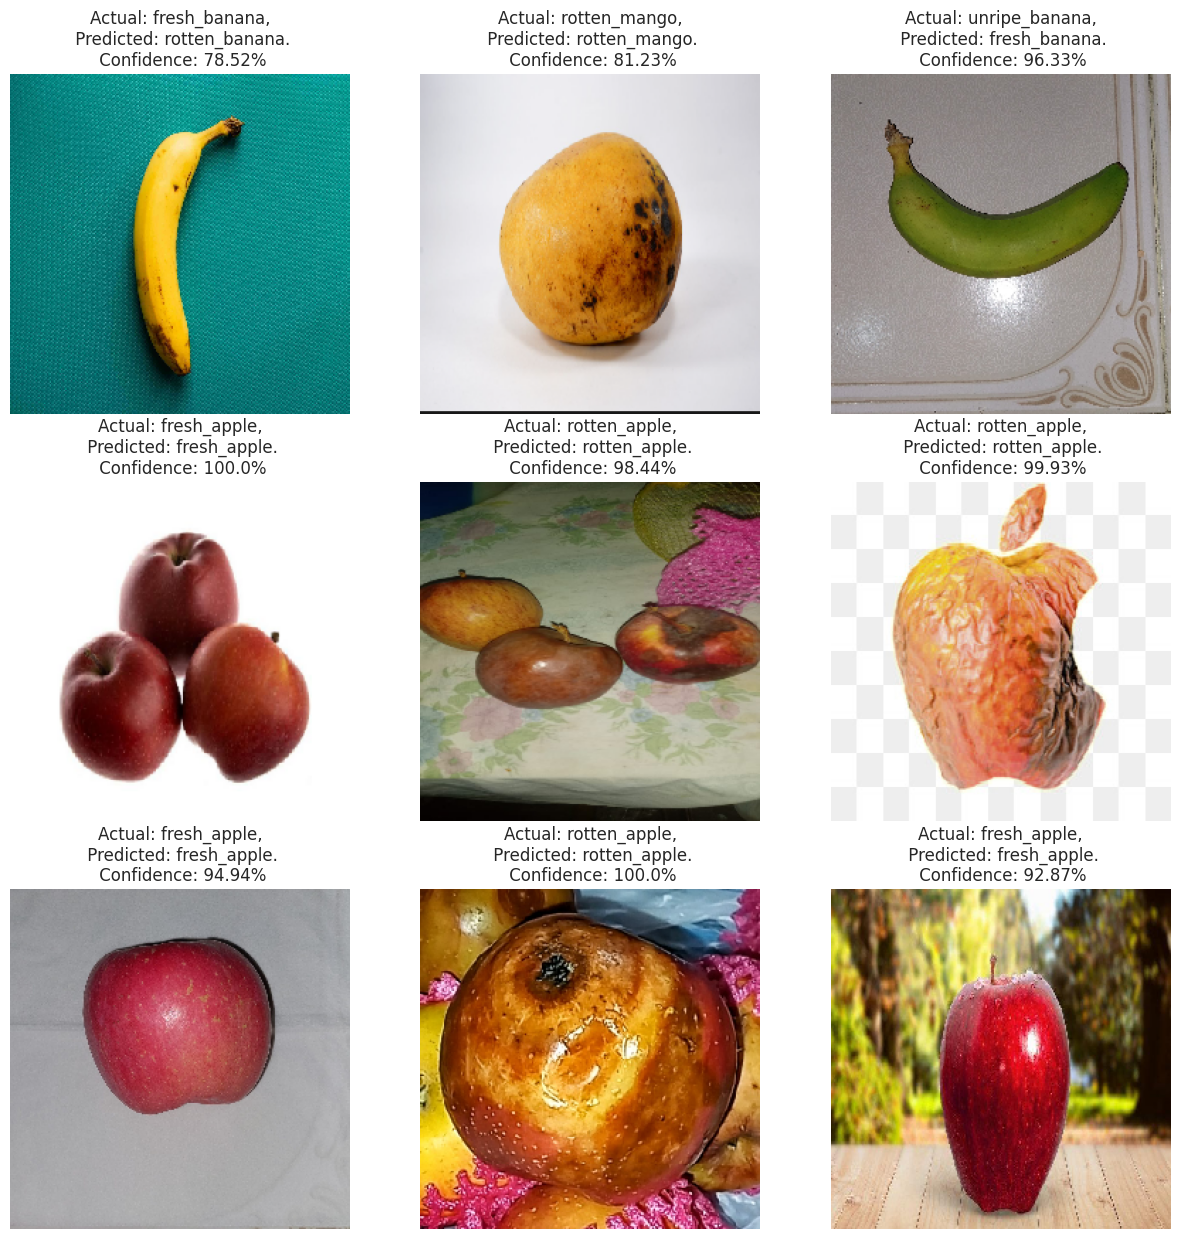

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test2_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break